##**Set The Enviroment**

###**Software Information**

In [ ]:
# Menggunakan platform bawaan Python untuk mengakses informasi sistem
import platform

# Informasi sistem
system_info = platform.uname()

# Menampilkan informasi sistem
print(system_info)


uname_result(system='Linux', node='ee93f22ebc4a', release='5.15.109+', version='#1 SMP Fri Jun 9 10:57:30 UTC 2023', machine='x86_64')


###**Import Dependences**

In [ ]:
import tensorflow as tf
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

In [ ]:
from keras.layers import BatchNormalization


###**Load Data**

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d noulam/tomato
!unzip tomato.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac022a2b-764c-4507-8dd9-4470b75763e4___RS_HL 9937.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/ac249839-fe21-45cd-9e09-f0023fa7ee3a___GH_HL Leaf 273.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdbf632-8d26-472d-874f-6d7df5cd0432___RS_HL 9897.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acdf2283-0e7c-4ccd-8817-1019e3a8ed20___RS_HL 9943.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy/acf28842-7821-4f31-ab73-2787e332e852___RS_HL 0011.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___h

###**Load Data (Small)**

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kaustubhb999/tomatoleaf

 95% 170M/179M [00:01<00:00, 207MB/s]
100% 179M/179M [00:01<00:00, 163MB/s]


In [ ]:
!unzip tomatoleaf.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-

###**set the path**

In [ ]:
#Set Hyperparameter of CNN
EPOCHS = 50
INIT_LR = 1e-3
#to avoid crashing due to less ram
BS = 1000
width=150
height=150
default_image_size = tuple((width,height))
depth=3
inputShape=(150,150,3)

#Set Label Class
labels=[
"Tomato___Tomato_mosaic_virus",
"Tomato___Early_blight",
"Tomato___Septoria_leaf_spot",
"Tomato___Bacterial_spot",
"Tomato___Target_Spot",
"Tomato___Spider_mites",
"Tomato___Tomato_Yellow_Leaf_Curl_Virus",
"Tomato___Late_blight",
"Tomato___healthy",
"Tomato___Leaf_Mold"
]

In [ ]:
# definisikan sebuah fungsi untuk mengubah data image kedalam numpy
def img_to_np(DIR,flatten=True):
  #canny edge detection by resizing
  cv_img=mpimg.imread(DIR,0)
  cv_img=cv2.resize(cv_img,default_image_size)
  img = np.uint8(cv_img)
  #img = np.uint8((0.2126 * img[:,:,0]) + np.uint8(0.7152 * img[:,:,1]) + np.uint8(0.0722 * img[:,:,2]))
  #flatten it
  if(flatten):
    img=img.flatten()
  return img

###**Path data**

In [ ]:
#Set jalur data
TRAIN_DIR = "/content/New Plant Diseases Dataset(Augmented)/train/"
TEST_DIR = "/content/New Plant Diseases Dataset(Augmented)/valid/"

###**Path Data (Small)**

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/tomato/train/"
TEST_DIR = "/content/drive/MyDrive/tomato/val/"

###**Load Data**

In [ ]:
#TRAIN_DIR="/kaggle/input/tomatoleaf/tomato/train/"
index=0
data={}
for FOLDER in os.listdir(TRAIN_DIR):
    for image_dir in os.listdir(TRAIN_DIR+FOLDER):
      if index not in data:
        data[index]=[]
      try:
        data[index].append(img_to_np(TRAIN_DIR+FOLDER+"/"+image_dir))
      except:
        print("Error to load the image "+TRAIN_DIR+FOLDER+"/"+image_dir)
    index=index+1

In [ ]:
#Menguah label kedalam bentuk binary
labelencoder = LabelBinarizer()
label=labelencoder.fit_transform([0,1,2,3,4,5,6,7,8,9])
label

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [ ]:
#membuat folder untuk training set
index=0
data=[]
for FOLDER in os.listdir(TRAIN_DIR):
    print(TRAIN_DIR+FOLDER)
    for image_dir in os.listdir(TRAIN_DIR+FOLDER):
      data.append({"x":img_to_np(TRAIN_DIR+FOLDER+"/"+image_dir,flatten=False),"y":label[index]})
    index=index+1
x,y=[],[]
for obj in data:
  x.append(obj["x"])
  y.append(obj["y"])
x_train = np.array(x,dtype=np.float16)
y_train = np.array(y,dtype=np.float16)

/content/drive/MyDrive/tomato/train/Tomato___Early_blight
/content/drive/MyDrive/tomato/train/Tomato___Bacterial_spot
/content/drive/MyDrive/tomato/train/Tomato___Late_blight
/content/drive/MyDrive/tomato/train/Tomato___Leaf_Mold
/content/drive/MyDrive/tomato/train/Tomato___Septoria_leaf_spot
/content/drive/MyDrive/tomato/train/Tomato___Spider_mites Two-spotted_spider_mite
/content/drive/MyDrive/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/drive/MyDrive/tomato/train/Tomato___Target_Spot
/content/drive/MyDrive/tomato/train/Tomato___Tomato_mosaic_virus
/content/drive/MyDrive/tomato/train/Tomato___healthy


In [ ]:
#membuat folder untuk test set
index=0
data=[]
for FOLDER in os.listdir(TEST_DIR):
    print(TRAIN_DIR+FOLDER)
    for image_dir in os.listdir(TEST_DIR+FOLDER):
      data.append({"x":img_to_np(TEST_DIR+FOLDER+"/"+image_dir,flatten=False),"y":label[index]})
    index=index+1
x,y=[],[]
for obj in data:
  x.append(obj["x"])
  y.append(obj["y"])
x_test = np.array(x,dtype=np.float16)
y_test = np.array(y,dtype=np.float16)

/content/drive/MyDrive/tomato/train/Tomato___Bacterial_spot
/content/drive/MyDrive/tomato/train/Tomato___Septoria_leaf_spot
/content/drive/MyDrive/tomato/train/Tomato___Early_blight
/content/drive/MyDrive/tomato/train/Tomato___Leaf_Mold
/content/drive/MyDrive/tomato/train/Tomato___Late_blight
/content/drive/MyDrive/tomato/train/Tomato___Spider_mites Two-spotted_spider_mite
/content/drive/MyDrive/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus
/content/drive/MyDrive/tomato/train/Tomato___healthy
/content/drive/MyDrive/tomato/train/Tomato___Target_Spot
/content/drive/MyDrive/tomato/train/Tomato___Tomato_mosaic_virus


##**Modeling**

####**CNN + Hyperparameter with Grid**

https://www.kaggle.com/code/mellonixie/image-classification-cnn-hyperparameter-tuning

In [ ]:
import numpy as np
import random
from tensorflow.keras.callbacks import ModelCheckpoint
# The cost function or objective function
hasil =[]
p_dropout=[]
p_dropsize=[]
p_opt=[]
def Fun(x):
  checkpoint_path = "model_CNN.h5"

  # Buat callback untuk ModelCheckpoint
  checkpoint_callback = ModelCheckpoint(
      checkpoint_path,
      monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
      save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
      mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
      verbose=1,    # Menampilkan pesan ketika checkpoint disimpan
      )
  dropout =[0.1,0.2,0.3,0.4,0.5]
  dropsize = [100, 500, 800, 1000, 2000]
  opt =['adam', 'adamax', 'nadam','adagrad']
  print("Sekarang adalah Dropout {}, Dropsize {} dan optimizer {}".format(dropout[int(x[0])],dropsize[int(x[1])], opt[int(x[2])]))
  input_shape = (150, 150, 3)
  model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
    ])
  # Membuat objek ImageDataGenerator untuk augmentasi data
  aug = ImageDataGenerator(  # Membalik gambar secara horizontal
                           fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
                             )
  #with tpu_strategy.scope():
  model1.compile(loss="binary_crossentropy", optimizer=opt[int(x[2])],metrics=["accuracy"])
  model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=dropsize[int(x[1])]),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // dropsize[int(x[1])],
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )
  scores = model1.evaluate(x_test, y_test)
  hasil.append(scores[1])
  p_dropout.append(dropout[int(x[0])])
  p_dropsize.append(dropsize[int(x[1])])
  p_opt.append(opt[int(x[2])])
  print("hasil :", scores[1]*100)
  print("fitness_function :", 1-scores[1])
  del model1
  del model_history
  tf.config.experimental.reset_memory_stats
  return 1-scores[1]
# Application of simple bounds/constraints
def simplebounds(s, Lb, Ub):
  # Apply the lower bound
   ns_tmp = s
   I = ns_tmp < Lb
   ns_tmp[I] = Lb[I]
   # Apply the upper bounds
   J = ns_tmp > Ub
   ns_tmp[J] = Ub[J]
   # Update this new move
   return ns_tmp
# Initialize all the default parameters
n = 5
t_max = 5
# parameter padding (int), dropout (float), batch size (int)
A = 1 # Initial loudness (constant or decreasing)
r0 = 1 # The initial pulse rate (constant or decreasing)
alpha = 0.97 # Parameter alpha
gamma = 0.1 # Parameter gamma
# Frequency range
Freq_min = 0 # Frequency minimum
Freq_max = 2 # Frequency maximum
t = 0 # Initialize iteration counter
d = 3 # Dimensions of the search variables
# Initialization of all the arrays
Freq = np.zeros(n) # Frequency-tuning array
v = np.zeros((n,d)) # Equivalnet velocities or increments
Lb = np.array([0,0,0]) # Lower bounds
Ub = np.array([4,4,3]) # Upper bounds
Sol = np.zeros((n,d))
Fitness = np.zeros(n)
S = np.zeros((n,d))
# Initialize the population/solutions
for i in range(n):
    Sol[i] = Lb + (Ub-Lb)*np.random.random(d)
    Sol[i,0]=int(Sol[i,0])
    Sol[i,1]=int(Sol[i,1])
    Sol[i,2]=int(Sol[i,2])
    Fitness[i] = Fun(Sol[i])
    print(Sol[i])
# Find the best solution of the initial population
fmin = min(Fitness)
I = np.where(Fitness==fmin)
best = Sol[I]
BestL=fmin
impav=0
kd=1
# Start the iterations -- the Bat Algorithm (BA) -- main loop
while t<t_max and kd==1 :
    # Varying loundness (A) and pulse emission rate (r)
    r = r0*(1 - np.exp(-1*gamma*t))
    A *= alpha
    # Loop over all bats/solutions
    for i in range(n):
        Freq[i] = Freq_min + (Freq_max-Freq_min)*np.random.uniform()
        v[i] = v[i] + (Sol[i]-best)*Freq[i]
        S[i] = Sol[i] + v[i]
        # Check a switching condition
        if np.random.uniform() < r:
            S[i] = best + 0.1*np.random.randn(1,d)*A
            # Check if the new solution is within the simple bounds
        S[i] = simplebounds(S[i], Lb, Ub)
        # Evaluate new solutions
        Fnew = Fun(S[i])
        # If the solution improves or not too loudness
        if ((Fnew <= Fitness[i]) and (np.random.uniform() > A)):
            Sol[i] = S[i]
            Fitness[i] = Fnew
        # Update the current best solution
        if Fnew <= fmin:
            best = S[i].copy()
            fmin = Fnew
    t += 1 # Update iteration counter
    # Display the results every 100 iterations
    if t%100==0:
        print('Iteration = ',t)
        print(best, fmin)
    if abs(fmin-BestL)<10**(-15):
        impav=impav+1
    else:
        impav=0
    if impav>=50:
        kd=0
    BestL=fmin
# Output the best solution
print('Best =', best, 'fmin=', fmin)

Sekarang adalah Dropout 0.4, Dropsize 500 dan optimizer nadam


<ipython-input-10-0e8c36f06060>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 4.6011 - accuracy: 0.1744
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to model_CNN.h5
3/3 [==============================] - 20s 1s/step - loss: 4.6011 - accuracy: 0.1744 - val_loss: 9.9692 - val_accuracy: 0.1000
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 1.5678 - accuracy: 0.5407
Epoch 2: val_accuracy did not improve from 0.10000
3/3 [==============================] - 2s 559ms/step - loss: 1.5678 - accuracy: 0.5407 - val_loss: 1.2870 - val_accuracy: 0.1000
Epoch 3/50
3/3 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.6443
Epoch 3: val_accuracy improved from 0.10000 to 0.10700, saving model to model_CNN.h5
3/3 [==============================] - 1s 577ms/step - loss: 0.1939 - accuracy: 0.6443 - val_loss: 0.6802 - val_accuracy: 0.1070
Epoch 4/50
3/3 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.6394
Epoch 4: val_accuracy did not improve from 0.10700
3/3 [==============================] - 1s 528ms/step - loss: 0.1741 - accuracy: 0.6394 - val_loss: 0.6077 - val_accuracy: 0.1010
Epoch 5/50
3/3 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 0.7720
Epoch 5: val_accuracy did not improve from 0.10700
3/3 [=============

In [ ]:
import numpy as np
import random
from tensorflow.keras.callbacks import ModelCheckpoint
# The cost function or objective function
hasil =[]
p_dropout=[]
p_dropsize=[]
p_opt=[]
def Fun(x):
  checkpoint_path = "model_CNN_SVM.h5"

  # Buat callback untuk ModelCheckpoint
  checkpoint_callback = ModelCheckpoint(
      checkpoint_path,
      monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
      save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
      mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
      verbose=1,    # Menampilkan pesan ketika checkpoint disimpan
      )
  dropout =[0.1,0.2,0.3,0.4,0.5]
  dropsize = [100, 500, 800, 1000, 2000]
  opt =['adam', 'adamax', 'nadam','adagrad']
  print("Sekarang adalah Dropout {}, Dropsize {} dan optimizer {}".format(dropout[int(x[0])],dropsize[int(x[1])], opt[int(x[2])]))
  input_shape = (150, 150, 3)
  model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
    ])
  # Membuat objek ImageDataGenerator untuk augmentasi data
  aug = ImageDataGenerator(  # Membalik gambar secara horizontal
                           fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
                             )
  #with tpu_strategy.scope():
  model1.compile(loss="binary_crossentropy", optimizer=opt[int(x[2])],metrics=["accuracy"])
  model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=dropsize[int(x[1])]),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // dropsize[int(x[1])],
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )
  scores = model1.evaluate(x_test, y_test)
  hasil.append(scores[1])
  p_dropout.append(dropout[int(x[0])])
  p_dropsize.append(dropsize[int(x[1])])
  p_opt.append(opt[int(x[2])])
  print("hasil :", scores[1]*100)
  print("fitness_function :", 1-scores[1])
  del model1
  del model_history
  tf.config.experimental.reset_memory_stats
  return 1-scores[1]

In [ ]:
import numpy as np
import random
from tensorflow.keras.callbacks import ModelCheckpoint
# The cost function or objective function
hasil =[]
p_dropout=[]
p_dropsize=[]
p_opt=[]
def Fun(x):
  checkpoint_path = "model_CNN_SVM.h5"

  # Buat callback untuk ModelCheckpoint
  checkpoint_callback = ModelCheckpoint(
      checkpoint_path,
      monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
      save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
      mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
      verbose=1,    # Menampilkan pesan ketika checkpoint disimpan
      )
  dropout =[0.1,0.2,0.3,0.4,0.5]
  dropsize = [100, 500, 800, 1000, 2000]
  opt =['adam', 'adamax', 'nadam','adagrad']
  print("Sekarang adalah Dropout {}, Dropsize {} dan optimizer {}".format(dropout[int(x[0])],dropsize[int(x[1])], opt[int(x[2])]))
  input_shape = (150, 150, 3)
  model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
    ])
  # Membuat objek ImageDataGenerator untuk augmentasi data
  aug = ImageDataGenerator(  # Membalik gambar secara horizontal
                           fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
                             )
  #with tpu_strategy.scope():
  model1.compile(loss="binary_crossentropy", optimizer=opt[int(x[2])],metrics=["accuracy"])
  model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=dropsize[int(x[1])]),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // dropsize[int(x[1])],
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )
  scores = model1.evaluate(x_test, y_test)
  hasil.append(scores[1])
  p_dropout.append(dropout[int(x[0])])
  p_dropsize.append(dropsize[int(x[1])])
  p_opt.append(opt[int(x[2])])
  print("hasil :", scores[1]*100)
  print("fitness_function :", 1-scores[1])
  del model1
  del model_history
  tf.config.experimental.reset_memory_stats
  return 1-scores[1]
# Application of simple bounds/constraints
def simplebounds(s, Lb, Ub):
  # Apply the lower bound
   ns_tmp = s
   I = ns_tmp < Lb
   ns_tmp[I] = Lb[I]
   # Apply the upper bounds
   J = ns_tmp > Ub
   ns_tmp[J] = Ub[J]
   # Update this new move
   return ns_tmp
# Initialize all the default parameters
n = 5
t_max = 5
# parameter padding (int), dropout (float), batch size (int)
A = 1 # Initial loudness (constant or decreasing)
r0 = 1 # The initial pulse rate (constant or decreasing)
alpha = 0.97 # Parameter alpha
gamma = 0.1 # Parameter gamma
# Frequency range
Freq_min = 0 # Frequency minimum
Freq_max = 2 # Frequency maximum
t = 0 # Initialize iteration counter
d = 3 # Dimensions of the search variables
# Initialization of all the arrays
Freq = np.zeros(n) # Frequency-tuning array
v = np.zeros((n,d)) # Equivalnet velocities or increments
Lb = np.array([0,0,0]) # Lower bounds
Ub = np.array([4,4,3]) # Upper bounds
Sol = np.zeros((n,d))
Fitness = np.zeros(n)
S = np.zeros((n,d))
# Initialize the population/solutions
for i in range(n):
    Sol[i] = Lb + (Ub-Lb)*np.random.random(d)
    Sol[i,0]=int(Sol[i,0])
    Sol[i,1]=int(Sol[i,1])
    Sol[i,2]=int(Sol[i,2])
    Fitness[i] = Fun(Sol[i])
    print(Sol[i])
# Find the best solution of the initial population
fmin = min(Fitness)
I = np.where(Fitness==fmin)
best = Sol[I]
BestL=fmin
impav=0
kd=1
# Start the iterations -- the Bat Algorithm (BA) -- main loop
while t<t_max and kd==1 :
    # Varying loundness (A) and pulse emission rate (r)
    r = r0*(1 - np.exp(-1*gamma*t))
    A *= alpha
    # Loop over all bats/solutions
    for i in range(n):
        Freq[i] = Freq_min + (Freq_max-Freq_min)*np.random.uniform()
        v[i] = v[i] + (Sol[i]-best)*Freq[i]
        S[i] = Sol[i] + v[i]
        # Check a switching condition
        if np.random.uniform() < r:
            S[i] = best + 0.1*np.random.randn(1,d)*A
            # Check if the new solution is within the simple bounds
        S[i] = simplebounds(S[i], Lb, Ub)
        # Evaluate new solutions
        Fnew = Fun(S[i])
        # If the solution improves or not too loudness
        if ((Fnew <= Fitness[i]) and (np.random.uniform() > A)):
            Sol[i] = S[i]
            Fitness[i] = Fnew
        # Update the current best solution
        if Fnew <= fmin:
            best = S[i].copy()
            fmin = Fnew
    t += 1 # Update iteration counter
    # Display the results every 100 iterations
    if t%100==0:
        print('Iteration = ',t)
        print(best, fmin)
    if abs(fmin-BestL)<10**(-15):
        impav=impav+1
    else:
        impav=0
    if impav>=50:
        kd=0
    BestL=fmin
# Output the best solution
print('Best =', best, 'fmin=', fmin)

In [ ]:
import numpy as np
import random
from tensorflow.keras.callbacks import ModelCheckpoint
# The cost function or objective function
hasil =[]
p_dropout=[]
p_dropsize=[]
p_opt=[]
def Fun(x):
  checkpoint_path = "model_CNN_SVM.h5"

  # Buat callback untuk ModelCheckpoint
  checkpoint_callback = ModelCheckpoint(
      checkpoint_path,
      monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
      save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
      mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
      verbose=1,    # Menampilkan pesan ketika checkpoint disimpan
      )
  dropout =[0.1,0.2,0.3,0.4,0.5]
  dropsize = [100, 500, 800, 1000, 2000]
  opt =['adam', 'adamax', 'nadam','adagrad']
  print("Sekarang adalah Dropout {}, Dropsize {} dan optimizer {}".format(dropout[int(x[0])],dropsize[int(x[1])], opt[int(x[2])]))
  input_shape = (150, 150, 3)
  model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(dropout[int(x[0])]),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
    ])
  # Membuat objek ImageDataGenerator untuk augmentasi data
  aug = ImageDataGenerator(  # Membalik gambar secara horizontal
                           fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
                             )
  #with tpu_strategy.scope():
  model1.compile(loss="binary_crossentropy", optimizer=opt[int(x[2])],metrics=["accuracy"])
  model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=dropsize[int(x[1])]),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // dropsize[int(x[1])],
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )
  scores = model1.evaluate(x_test, y_test)
  hasil.append(scores[1])
  p_dropout.append(dropout[int(x[0])])
  p_dropsize.append(dropsize[int(x[1])])
  p_opt.append(opt[int(x[2])])
  print("hasil :", scores[1]*100)
  print("fitness_function :", 1-scores[1])
  del model1
  del model_history
  return 1-scores[1]
# Application of simple bounds/constraints
def simplebounds(s, Lb, Ub):
  # Apply the lower bound
   ns_tmp = s
   I = ns_tmp < Lb
   ns_tmp[I] = Lb[I]
   # Apply the upper bounds
   J = ns_tmp > Ub
   ns_tmp[J] = Ub[J]
   # Update this new move
   return ns_tmp
# Initialize all the default parameters
n = 5
t_max = 5
# parameter padding (int), dropout (float), batch size (int)
A = 1 # Initial loudness (constant or decreasing)
r0 = 1 # The initial pulse rate (constant or decreasing)
alpha = 0.97 # Parameter alpha
gamma = 0.1 # Parameter gamma
# Frequency range
Freq_min = 0 # Frequency minimum
Freq_max = 2 # Frequency maximum
t = 0 # Initialize iteration counter
d = 3 # Dimensions of the search variables
# Initialization of all the arrays
Freq = np.zeros(n) # Frequency-tuning array
v = np.zeros((n,d)) # Equivalnet velocities or increments
Lb = np.array([0,0,0]) # Lower bounds
Ub = np.array([4,4,3]) # Upper bounds
Sol = np.zeros((n,d))
Fitness = np.zeros(n)
S = np.zeros((n,d))
# Initialize the population/solutions
for i in range(n):
    Sol[i] = Lb + (Ub-Lb)*np.random.random(d)
    Sol[i,0]=int(Sol[i,0])
    Sol[i,1]=int(Sol[i,1])
    Sol[i,2]=int(Sol[i,2])
    Fitness[i] = Fun(Sol[i])
    print(Sol[i])
# Find the best solution of the initial population
fmin = min(Fitness)
I = np.where(Fitness==fmin)
best = Sol[I]
BestL=fmin
impav=0
kd=1
# Start the iterations -- the Bat Algorithm (BA) -- main loop
while t<t_max and kd==1 :
    # Varying loundness (A) and pulse emission rate (r)
    r = r0*(1 - np.exp(-1*gamma*t))
    A *= alpha
    # Loop over all bats/solutions
    for i in range(n):
        Freq[i] = Freq_min + (Freq_max-Freq_min)*np.random.uniform()
        v[i] = v[i] + (Sol[i]-best)*Freq[i]
        S[i] = Sol[i] + v[i]
        # Check a switching condition
        if np.random.uniform() < r:
            S[i] = best + 0.1*np.random.randn(1,d)*A
            # Check if the new solution is within the simple bounds
        S[i] = simplebounds(S[i], Lb, Ub)
        # Evaluate new solutions
        Fnew = Fun(S[i])
        # If the solution improves or not too loudness
        if ((Fnew <= Fitness[i]) and (np.random.uniform() > A)):
            Sol[i] = S[i]
            Fitness[i] = Fnew
        # Update the current best solution
        if Fnew <= fmin:
            best = S[i].copy()
            fmin = Fnew
    t += 1 # Update iteration counter
    # Display the results every 100 iterations
    if t%100==0:
        print('Iteration = ',t)
        print(best, fmin)
    if abs(fmin-BestL)<10**(-15):
        impav=impav+1
    else:
        impav=0
    if impav>=50:
        kd=0
    BestL=fmin
# Output the best solution
print('Best =', best, 'fmin=', fmin)

Sekarang adalah Dropout 0.1, Dropsize 500 dan optimizer adam


<ipython-input-13-f053e33453ec>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 26: val_accuracy did not improve from 0.91700
100/100 [==============================] - 4s 38ms/step - loss: 0.0093 - accuracy: 0.9891 - val_loss: 0.0826 - val_accuracy: 0.9140
Epoch 27/50
100/100 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9949
Epoch 27: val_accuracy did not improve from 0.91700
100/100 [==============================] - 3s 28ms/step - loss: 0.0049 - accuracy: 0.9949 - val_loss: 0.0845 - val_accuracy: 0.9070
Epoch 28/50
100/100 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9908
Epoch 28: val_accuracy did not improve from 0.91700
100/100 [==============================] - 3s 31ms/step - loss: 0.0083 - accuracy: 0.9908 - val_loss: 0.0983 - val_accuracy: 0.8950
Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9864
Epoch 29: val_accuracy did not improve from 0.91700
100/100 [==============================] - 3s 

In [ ]:
import tensorflow as tf

input_shape = (150, 150, 3)

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
])

# Pengaturan kecepatan pembelajaran
opt = tf.keras.optimizers.Nadam(learning_rate=0.001)


In [ ]:
# Membuat objek ImageDataGenerator untuk augmentasi data
aug = ImageDataGenerator(
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
)

In [ ]:
# Tentukan path untuk menyimpan checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "model_CNN1.h5"

# Buat callback untuk ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
    save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
    mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
    verbose=1  # Menampilkan pesan ketika checkpoint disimpan
)

In [ ]:
import time

# Simpan waktu awal pelatihan
start_time = time.time()

BS = 100
# with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, verbose=1, callbacks=[checkpoint_callback]
)

# Hitung waktu yang diperlukan untuk pelatihan
end_time = time.time()
training_time = end_time - start_time

print("Waktu pelatihan:", training_time, "detik")


Epoch 1/100


<ipython-input-19-37371d5514cf>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


100/100 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.3016
Epoch 1: val_accuracy improved from -inf to 0.63400, saving model to model_CNN1.h5
100/100 [==============================] - 20s 66ms/step - loss: 0.6898 - accuracy: 0.3016 - val_loss: 0.1871 - val_accuracy: 0.6340


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.5772
Epoch 2: val_accuracy improved from 0.63400 to 0.74200, saving model to model_CNN1.h5
100/100 [==============================] - 5s 50ms/step - loss: 0.2065 - accuracy: 0.5772 - val_loss: 0.1347 - val_accuracy: 0.7420
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.7006
Epoch 3: val_accuracy improved from 0.74200 to 0.78100, saving model to model_CNN1.h5
100/100 [==============================] - 6s 61ms/step - loss: 0.1563 - accuracy: 0.7006 - val_loss: 0.1129 - val_accuracy: 0.7810
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1231 - accuracy: 0.7816
Epoch 4: val_accuracy improved from 0.78100 to 0.82700, saving model to model_CNN1.h5
100/100 [==============================] - 5s 52ms/step - loss: 0.1228 - accuracy: 0.7823 - val_loss: 0.0921 - val_accuracy: 0.8270
Epoch 5/100
 99/100 [============================>.] - 

In [ ]:
import numpy as np
import time
from sklearn.metrics import classification_report

# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN1.h5')

# Generate model predictions on the test data with time measurement
start_time = time.time()
y_pred = loaded_model.predict(x_test)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for prediction:", elapsed_time, "seconds")

y_pred_classes = np.argmax(y_pred, axis=1)
# Create and print the classification report
report = classification_report(np.argmax(y_test, axis=1), y_pred_classes)
print(report)

scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is:", scores[1] * 100, "%")


32/32 [==============================] - 0s 6ms/step
Time taken for prediction: 1.4114015102386475 seconds
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.98      0.93      0.95       100
           2       1.00      0.98      0.99       100
           3       1.00      0.98      0.99       100
           4       0.96      1.00      0.98       100
           5       0.96      0.90      0.93       100
           6       0.98      0.95      0.96       100
           7       0.95      1.00      0.98       100
           8       0.97      0.95      0.96       100
           9       0.88      0.97      0.92       100

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

32/32 [==============================] - 0s 8ms/step - loss: 0.0364 - accuracy: 0.9620
Accuracy is: 96.20000123977661 %


####**Model CNN + SVM**

In [ ]:
import tensorflow as tf

input_shape = (150, 150, 3)

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
])

# Pengaturan kecepatan pembelajaran
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
# Tentukan path untuk menyimpan checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "model_CNN_SVM.h5"

# Buat callback untuk ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
    save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
    mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
    verbose=1  # Menampilkan pesan ketika checkpoint disimpan
)

In [ ]:
# Membuat objek ImageDataGenerator untuk augmentasi data
aug = ImageDataGenerator(
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
)

In [ ]:
import time

# Memulai waktu komputasi
start_time = time.time()

# ... kode lainnya ...

# Melatih model
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
)

# Menghentikan waktu komputasi setelah pelatihan selesai
end_time = time.time()

# Menghitung waktu komputasi total
elapsed_time = end_time - start_time

# Menampilkan waktu komputasi
print(f"Waktu komputasi total: {elapsed_time} detik")


<ipython-input-16-8349fbfb8de8>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50


In [ ]:
import numpy as np
import time
from sklearn.metrics import classification_report

# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNNSVM.h5')

# Generate model predictions on the test data with time measurement
start_time = time.time()
y_pred = loaded_model.predict(x_test)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for prediction:", elapsed_time, "seconds")

y_pred_classes = np.argmax(y_pred, axis=1)
# Create and print the classification report
report = classification_report(np.argmax(y_test, axis=1), y_pred_classes)
print(report)

scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is:", scores[1] * 100, "%")


144/144 [==============================] - 1s 4ms/step
Time taken for prediction: 2.6678502559661865 seconds
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       463
           1       0.96      0.95      0.96       435
           2       0.90      0.96      0.93       480
           3       0.99      1.00      0.99       448
           4       0.99      0.99      0.99       481
           5       0.96      0.93      0.94       436
           6       0.99      0.96      0.98       470
           7       0.97      0.99      0.98       425
           8       0.99      0.98      0.99       490
           9       0.95      0.94      0.95       457

    accuracy                           0.96      4585
   macro avg       0.96      0.96      0.96      4585
weighted avg       0.96      0.96      0.96      4585

144/144 [==============================] - 1s 5ms/step - loss: 0.0246 - accuracy: 0.9642
Accuracy is: 96.42311930656433 %


In [ ]:
feature_extractor = tf.keras.Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('flatten_5').output)

In [ ]:
train_features = feature_extractor.predict(x_train)

574/574 [==============================] - 2s 4ms/step


In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')  # Anda dapat memilih kernel lain jika diinginkan
svm_classifier.fit(train_features, np.argmax(y_train, axis=1))

SVC()

In [ ]:
test_features = feature_extractor.predict(x_test)

144/144 [==============================] - 1s 3ms/step


In [ ]:
import time
from sklearn.metrics import accuracy_score

# Prediksi menggunakan model SVM dengan waktu pengukuran
start_time = time.time()
y_pred = svm_classifier.predict(test_features)
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken for prediction:", elapsed_time, "seconds")
# Menghitung akurasi
accuracy = accuracy_score(np.argmax(y_test, axis = 1), y_pred)
print("Accuracy:", accuracy*100,"%")


Time taken for prediction: 884.5998253822327 seconds
Accuracy: 96.29225736095965 %


####**Model CNN Adam**

In [ ]:
import tensorflow as tf

input_shape = (150, 150, 3)

model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Tambahkan lapisan dropout
    tf.keras.layers.Dense(10, activation='softmax', name='output_layers')
])

# Pengaturan kecepatan pembelajaran
opt = tf.keras.optimizers.Adam(learning_rate=0.001)


In [ ]:
# Membuat objek ImageDataGenerator untuk augmentasi data
aug = ImageDataGenerator(  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
)

In [ ]:
# Tentukan path untuk menyimpan checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "model_CNN1.h5"

# Buat callback untuk ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
    save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
    mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
    verbose=1  # Menampilkan pesan ketika checkpoint disimpan
)

In [ ]:
#with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN.h5')

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

####**Model CNN Adamax**

In [ ]:
opt1 = tf.keras.optimizers.Adamax(learning_rate=0.001)
opt2 = tf.keras.optimizers.Nadam(learning_rate=0.001)
opt3 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
opt4 = tf.keras.optimizers.Adagrad(learning_rate=0.001)
opt5 = tf.keras.optimizers.SGD(learning_rate=0.001)

In [ ]:
model1.compile(loss="binary_crossentropy", optimizer=opt1,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )

<ipython-input-21-6553c68ff9ec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.7520 - accuracy: 0.1554
Epoch 1: val_accuracy improved from -inf to 0.38081, saving model to model_CNN2.h5
18/18 [==============================] - 19s 945ms/step - loss: 1.7520 - accuracy: 0.1554 - val_loss: 0.2852 - val_accuracy: 0.3808
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.2766 - accuracy: 0.3734
Epoch 2: val_accuracy improved from 0.38081 to 0.62312, saving model to model_CNN2.h5
18/18 [==============================] - 14s 748ms/step - loss: 0.2766 - accuracy: 0.3734 - val_loss: 0.2000 - val_accuracy: 0.6231
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.2170 - accuracy: 0.5622
Epoch 3: val_accuracy improved from 0.62312 to 0.71821, saving model to model_CNN2.h5
18/18 [==============================] - 14s 757ms/step - loss: 0.2170 - accuracy: 0.5622 - val_loss: 0.1558 - val_accuracy: 0.7182
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss:

In [ ]:
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN2.h5')

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already compiled and fitted the model
# model.compile(...)

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)

144/144 [==============================] - 9s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       457
           1       0.99      0.98      0.99       481
           2       0.90      0.94      0.92       480
           3       0.98      0.96      0.97       425
           4       0.95      0.93      0.94       463
           5       0.96      1.00      0.98       448
           6       0.93      0.92      0.93       436
           7       0.98      0.97      0.97       470
           8       0.97      0.99      0.98       490
           9       0.95      0.97      0.96       435

    accuracy                           0.96      4585
   macro avg       0.96      0.96      0.96      4585
weighted avg       0.96      0.96      0.96      4585



In [ ]:
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 2s 11ms/step - loss: 0.0288 - accuracy: 0.9586
Accuracy is :95.85605263710022 %


####**Model CNN Nadam**

In [ ]:
model1.compile(loss="binary_crossentropy", optimizer=opt2,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )

<ipython-input-24-a7bac5ee49d1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.3239 - accuracy: 0.1890
Epoch 1: val_accuracy improved from -inf to 0.42726, saving model to model_CNN3.h5
18/18 [==============================] - 38s 1s/step - loss: 1.3239 - accuracy: 0.1890 - val_loss: 0.2764 - val_accuracy: 0.4273
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.3113
Epoch 2: val_accuracy did not improve from 0.42726
18/18 [==============================] - 13s 702ms/step - loss: 0.3125 - accuracy: 0.3113 - val_loss: 0.2589 - val_accuracy: 0.3961
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.4882
Epoch 3: val_accuracy improved from 0.42726 to 0.68353, saving model to model_CNN3.h5
18/18 [==============================] - 13s 716ms/step - loss: 0.2439 - accuracy: 0.4882 - val_loss: 0.1703 - val_accuracy: 0.6835
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.6257
Epoch 4: va

In [ ]:
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN3.h5')

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       457
           1       0.99      0.99      0.99       481
           2       0.94      0.89      0.92       480
           3       0.97      1.00      0.98       425
           4       0.93      0.93      0.93       463
           5       0.98      0.99      0.99       448
           6       0.93      0.92      0.93       436
           7       0.99      0.98      0.98       470
           8       0.99      0.99      0.99       490
           9       0.95      0.93      0.94       435

    accuracy                           0.96      4585
   macro avg       0.96      0.96      0.96      4585
weighted avg       0.96      0.96      0.96      4585

144/144 [==============================] - 2s 11ms/step - loss: 0.0270 - accuracy: 0.9575
Accuracy is :95.74699997901917 %


####**Model CNN RMSproop**

In [ ]:
model1.compile(loss="binary_crossentropy", optimizer=opt3,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )

<ipython-input-16-69b729b629ac>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 3.7170 - accuracy: 0.1155
Epoch 1: val_accuracy improved from -inf to 0.18953, saving model to model_CNN3.h5
18/18 [==============================] - 46s 1s/step - loss: 3.7170 - accuracy: 0.1155 - val_loss: 0.3543 - val_accuracy: 0.1895
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.1897
Epoch 2: val_accuracy improved from 0.18953 to 0.23904, saving model to model_CNN3.h5
18/18 [==============================] - 13s 710ms/step - loss: 0.3575 - accuracy: 0.1897 - val_loss: 0.3299 - val_accuracy: 0.2390
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.1873
Epoch 3: val_accuracy improved from 0.23904 to 0.39237, saving model to model_CNN3.h5
18/18 [==============================] - 13s 713ms/step - loss: 0.3988 - accuracy: 0.1873 - val_loss: 0.2903 - val_accuracy: 0.3924
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN3.h5')

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       470
           1       0.92      0.86      0.89       457
           2       0.96      0.98      0.97       448
           3       0.97      0.99      0.98       481
           4       0.96      0.97      0.97       425
           5       0.89      0.94      0.91       435
           6       0.92      0.83      0.87       436
           7       0.91      0.92      0.91       463
           8       0.86      0.89      0.88       480
           9       0.98      0.99      0.98       490

    accuracy                           0.93      4585
   macro avg       0.93      0.93      0.93      4585
weighted avg       0.93      0.93      0.93      4585

144/144 [==============================] - 2s 10ms/step - loss: 0.0451 - accuracy: 0.9304
Accuracy is :93.04252862930298 %


####**Model CNN Adagrad**

In [ ]:
model1.compile(loss="binary_crossentropy", optimizer=opt4,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )

<ipython-input-18-53c54b900150>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.5156 - accuracy: 0.1137
Epoch 1: val_accuracy improved from -inf to 0.19280, saving model to model_CNN4.h5
18/18 [==============================] - 44s 1s/step - loss: 1.5156 - accuracy: 0.1137 - val_loss: 0.3340 - val_accuracy: 0.1928
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.1371
Epoch 2: val_accuracy improved from 0.19280 to 0.25867, saving model to model_CNN4.h5
18/18 [==============================] - 13s 697ms/step - loss: 0.4110 - accuracy: 0.1371 - val_loss: 0.3189 - val_accuracy: 0.2587
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.1662
Epoch 3: val_accuracy improved from 0.25867 to 0.29553, saving model to model_CNN4.h5
18/18 [==============================] - 13s 710ms/step - loss: 0.3832 - accuracy: 0.1662 - val_loss: 0.3090 - val_accuracy: 0.2955
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN4.h5')

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.79      0.53      0.64       470
           1       0.64      0.51      0.56       457
           2       0.73      0.91      0.81       448
           3       0.79      0.95      0.86       481
           4       0.72      0.75      0.74       425
           5       0.67      0.63      0.65       435
           6       0.45      0.39      0.42       436
           7       0.63      0.53      0.57       463
           8       0.53      0.50      0.51       480
           9       0.64      0.91      0.75       490

    accuracy                           0.66      4585
   macro avg       0.66      0.66      0.65      4585
weighted avg       0.66      0.66      0.65      4585

144/144 [==============================] - 2s 10ms/step - loss: 0.1883 - accuracy: 0.6635
Accuracy is :66.34678244590759 %


####**Model CNN SGD**

In [ ]:
model1.compile(loss="binary_crossentropy", optimizer=opt5,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )

<ipython-input-17-9160584959b1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.8865 - accuracy: 0.1030
Epoch 1: val_accuracy improved from -inf to 0.13021, saving model to model_CNN5.h5
18/18 [==============================] - 43s 1s/step - loss: 1.8865 - accuracy: 0.1030 - val_loss: 0.3865 - val_accuracy: 0.1302
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.1155
Epoch 2: val_accuracy improved from 0.13021 to 0.16619, saving model to model_CNN5.h5
18/18 [==============================] - 13s 689ms/step - loss: 0.5380 - accuracy: 0.1155 - val_loss: 0.3422 - val_accuracy: 0.1662
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.1305
Epoch 3: val_accuracy improved from 0.16619 to 0.19564, saving model to model_CNN5.h5
18/18 [==============================] - 13s 698ms/step - loss: 0.4619 - accuracy: 0.1305 - val_loss: 0.3302 - val_accuracy: 0.1956
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN4.h5')

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

###**Pretrained Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Sesuaikan jumlah kelas dengan dataset Anda
num_classes = 10

# Load model pre-trained ResNet-152V2 tanpa lapisan Dense terakhir
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False
# Tambahkan lapisan Dense baru sesuai dengan jumlah kelas
#x = GlobalAveragePooling2D()(base_model.output)
# our layers - you can add more if you want
x = Flatten()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan base model ResNet-152V2 dengan lapisan Dense baru
model_resnet152v2 = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model_resnet152v2.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

model_resnet152v2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
# Membuat objek ImageDataGenerator untuk augmentasi data
aug = ImageDataGenerator(
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Mengisi piksel yang kosong dengan piksel terdekat
)

In [ ]:
# Tentukan path untuk menyimpan checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "model_resnet.h5"

# Buat callback untuk ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
    save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
    mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
    verbose=1  # Menampilkan pesan ketika checkpoint disimpan
)

In [ ]:
import time

# Simpan waktu awal pelatihan
start_time = time.time()

BS = 100
model_history = model_resnet152v2.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, verbose=1, callbacks=[checkpoint_callback]
)

# Hitung waktu yang diperlukan untuk pelatihan
end_time = time.time()
training_time = end_time - start_time

print("Waktu pelatihan:", training_time, "detik")


Epoch 1/100


<ipython-input-25-0d67b35035f9>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model_resnet152v2.fit_generator(


100/100 [==============================] - ETA: 0s - loss: 161.0217 - accuracy: 0.2867
Epoch 1: val_accuracy improved from -inf to 0.39600, saving model to model_resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 36s 249ms/step - loss: 161.0217 - accuracy: 0.2867 - val_loss: 91.5591 - val_accuracy: 0.3960
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 57.0051 - accuracy: 0.4692
Epoch 2: val_accuracy did not improve from 0.39600
100/100 [==============================] - 16s 159ms/step - loss: 57.0051 - accuracy: 0.4692 - val_loss: 85.6350 - val_accuracy: 0.3670
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 58.4706 - accuracy: 0.5008
Epoch 3: val_accuracy improved from 0.39600 to 0.47400, saving model to model_resnet.h5
100/100 [==============================] - 22s 218ms/step - loss: 58.4706 - accuracy: 0.5008 - val_loss: 38.3058 - val_accuracy: 0.4740
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 49.5702 - accuracy: 0.5638
Epoch 4: val_accuracy improved from 0.47400 to 0.57200, saving model to model_resnet.h5
100/100 [==============================] - 22s 218ms/step - loss: 49.5

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Sesuaikan jumlah kelas dengan dataset Anda
num_classes = 10

# Load model pre-trained VGG16 tanpa lapisan Dense terakhir
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False
# Tambahkan lapisan Dense baru sesuai dengan jumlah kelas
x = Flatten()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan base model VGG16 dengan lapisan Dense baru
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_vgg16.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Tentukan path untuk menyimpan checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "VGG16.h5"

# Buat callback untuk ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
    save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
    mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
    verbose=1  # Menampilkan pesan ketika checkpoint disimpan
)

In [ ]:
import time

# Simpan waktu awal pelatihan
start_time = time.time()

BS = 100
model_history = model_vgg16.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, verbose=1, callbacks=[checkpoint_callback]
)

# Hitung waktu yang diperlukan untuk pelatihan
end_time = time.time()
training_time = end_time - start_time

print("Waktu pelatihan:", training_time, "detik")


<ipython-input-19-8b462c5965fd>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model_vgg16.fit_generator(


Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.6317
Epoch 1: val_accuracy improved from -inf to 0.73400, saving model to VGG16.h5
100/100 [==============================] - 25s 118ms/step - loss: 0.7884 - accuracy: 0.6317 - val_loss: 0.4454 - val_accuracy: 0.7340


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.8591
Epoch 2: val_accuracy improved from 0.73400 to 0.77100, saving model to VGG16.h5
100/100 [==============================] - 10s 95ms/step - loss: 0.1964 - accuracy: 0.8591 - val_loss: 0.3376 - val_accuracy: 0.7710
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9065
Epoch 3: val_accuracy improved from 0.77100 to 0.79600, saving model to VGG16.h5
100/100 [==============================] - 9s 94ms/step - loss: 0.1254 - accuracy: 0.9065 - val_loss: 0.3187 - val_accuracy: 0.7960
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9244
Epoch 4: val_accuracy improved from 0.79600 to 0.80600, saving model to VGG16.h5
100/100 [==============================] - 9s 92ms/step - loss: 0.0970 - accuracy: 0.9244 - val_loss: 0.3435 - val_accuracy: 0.8060
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Sesuaikan jumlah kelas dengan dataset Anda
num_classes = 10

# Load model pre-trained InceptionV3 tanpa lapisan Dense terakhir
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3) )
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False
# Tambahkan lapisan Dense baru sesuai dengan jumlah kelas
#x = GlobalAveragePooling2D()(base_model.output)
x = Flatten()(base_model.output)
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan base model InceptionV3 dengan lapisan Dense baru
model_inception_v3 = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model_inception_v3.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

model_inception_v3.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94

In [ ]:
# Tentukan path untuk menyimpan checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "InceptionV3.h5"

# Buat callback untuk ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Pilih metrik yang ingin Anda pantau
    save_best_only=True,  # Hanya menyimpan model terbaik berdasarkan metrik yang dipantau
    mode='max',  # Mode 'max' untuk akurasi, 'min' untuk loss
    verbose=1  # Menampilkan pesan ketika checkpoint disimpan
)

In [ ]:
import time

# Simpan waktu awal pelatihan
start_time = time.time()

BS = 100
model_history = model_inception_v3.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, verbose=1, callbacks=[checkpoint_callback]
)

# Hitung waktu yang diperlukan untuk pelatihan
end_time = time.time()
training_time = end_time - start_time

print("Waktu pelatihan:", training_time, "detik")


Epoch 1/100


<ipython-input-23-3a4be4281ae0>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model_inception_v3.fit_generator(


100/100 [==============================] - ETA: 0s - loss: 4.5157 - accuracy: 0.3522
Epoch 1: val_accuracy improved from -inf to 0.43100, saving model to InceptionV3.h5
100/100 [==============================] - 19s 129ms/step - loss: 4.5157 - accuracy: 0.3522 - val_loss: 1.8706 - val_accuracy: 0.4310
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 2.4007 - accuracy: 0.4676
Epoch 2: val_accuracy improved from 0.43100 to 0.48500, saving model to InceptionV3.h5
100/100 [==============================] - 22s 221ms/step - loss: 2.4007 - accuracy: 0.4676 - val_loss: 1.9887 - val_accuracy: 0.4850
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 2.2076 - accuracy: 0.5169
Epoch 3: val_accuracy did not improve from 0.48500
100/100 [==============================] - 7s 70ms/step - loss: 2.2031 - accuracy: 0.5175 - val_loss: 2.1775 - val_accuracy: 0.4370
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 2.0569 - accuracy: 0.5381
Ep

In [ ]:
model_vgg16_history = model_vgg16.fit_generator(
    aug.flow(x_train, y_train, batch_size=4),
    validation_data=(x_test, y_test),
    epochs=50
    )

Epoch 1/50


<ipython-input-14-00172d36770f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg16_history = model_vgg16.fit_generator(


4587/4587 [==============================] - 51s 9ms/step - loss: 0.9406 - accuracy: 0.7836 - val_loss: 0.8809 - val_accuracy: 0.8539
Epoch 2/50
4587/4587 [==============================] - 38s 8ms/step - loss: 0.6526 - accuracy: 0.8988 - val_loss: 1.1167 - val_accuracy: 0.8534
Epoch 3/50
4587/4587 [==============================] - 39s 8ms/step - loss: 0.4922 - accuracy: 0.9363 - val_loss: 1.1771 - val_accuracy: 0.8611
Epoch 4/50
4587/4587 [==============================] - 38s 8ms/step - loss: 0.4219 - accuracy: 0.9509 - val_loss: 1.0635 - val_accuracy: 0.8831
Epoch 5/50
4587/4587 [==============================] - 38s 8ms/step - loss: 0.3514 - accuracy: 0.9633 - val_loss: 1.2569 - val_accuracy: 0.8807
Epoch 6/50
4587/4587 [==============================] - 38s 8ms/step - loss: 0.2961 - accuracy: 0.9723 - val_loss: 1.4261 - val_accuracy: 0.8781
Epoch 7/50
4587/4587 [==============================] - 38s 8ms/step - loss: 0.2754 - accuracy: 0.9750 - val_loss: 1.3585 - val_accuracy: 0.8

In [ ]:
# Save the model in Keras HDF5 format
model1.save('model_checkpoint_ADAM.h5')


In [ ]:
model_vgg16.save('Model_VGG.h5')

In [ ]:
model_inception_v3.save('/content/model_inception_v3.h5')

In [ ]:
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_inception_v3.h5')

In [ ]:
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_checkpoint_ADAM.h5')

In [ ]:
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/Model_VGG.h5')

In [ ]:
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 12s 19ms/step - loss: 17.9776 - accuracy: 0.6142
Accuracy is :61.41766905784607 %


In [ ]:
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 1s 8ms/step - loss: 0.0316 - accuracy: 0.9520
Accuracy is :95.20174264907837 %


In [ ]:
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 4s 23ms/step - loss: 3.3484 - accuracy: 0.8899
Accuracy is :88.98582458496094 %


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already compiled and fitted the model
# model.compile(...)

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)

144/144 [==============================] - 3s 15ms/step
              precision    recall  f1-score   support

           0       0.56      0.37      0.44       436
           1       0.52      0.44      0.48       457
           2       0.80      0.68      0.73       425
           3       0.52      0.76      0.62       435
           4       0.79      0.20      0.32       480
           5       0.85      0.68      0.76       448
           6       0.55      0.84      0.66       490
           7       0.45      0.75      0.56       470
           8       0.90      0.81      0.86       481
           9       0.60      0.61      0.60       463

    accuracy                           0.61      4585
   macro avg       0.65      0.61      0.60      4585
weighted avg       0.65      0.61      0.60      4585



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already compiled and fitted the model
# model.compile(...)

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)

144/144 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       480
           1       0.92      0.93      0.93       457
           2       0.98      0.99      0.98       481
           3       0.97      0.98      0.98       425
           4       0.95      0.95      0.95       435
           5       0.91      0.92      0.92       436
           6       0.97      0.97      0.97       470
           7       0.94      0.93      0.94       463
           8       0.98      0.98      0.98       490
           9       0.97      1.00      0.98       448

    accuracy                           0.95      4585
   macro avg       0.95      0.95      0.95      4585
weighted avg       0.95      0.95      0.95      4585



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have already compiled and fitted the model
# model.compile(...)

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)

144/144 [==============================] - 3s 22ms/step
              precision    recall  f1-score   support

           0       0.89      0.80      0.85       436
           1       0.75      0.86      0.80       457
           2       0.93      0.96      0.94       425
           3       0.86      0.92      0.89       435
           4       0.79      0.82      0.81       480
           5       0.96      0.98      0.97       448
           6       0.96      0.98      0.97       490
           7       0.91      0.84      0.87       470
           8       0.94      0.94      0.94       481
           9       0.94      0.81      0.87       463

    accuracy                           0.89      4585
   macro avg       0.89      0.89      0.89      4585
weighted avg       0.89      0.89      0.89      4585



In [ ]:
import pandas as pd
# Parse the classification report and extract relevant metrics for each class
lines = report.split('\n')[2:-5]  # Skip the first two lines and last 5 lines
class_names, precision, recall, f1_score, support = [], [], [], [], []

for line in lines:
    parts = line.split()
    if len(parts) < 2:
        continue
    class_names.append(parts[0])
    precision.append(float(parts[1]))
    recall.append(float(parts[2]))
    f1_score.append(float(parts[3]))
    support.append(int(parts[4]))

# Create a DataFrame from the extracted data
data = {
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Support': support
}
df = pd.DataFrame(data)

df

Class  Precision  Recall  F1 Score  Support
0     0       0.89    0.80      0.85      436
1     1       0.75    0.86      0.80      457
2     2       0.93    0.96      0.94      425
3     3       0.86    0.92      0.89      435
4     4       0.79    0.82      0.81      480
5     5       0.96    0.98      0.97      448
6     6       0.96    0.98      0.97      490
7     7       0.91    0.84      0.87      470
8     8       0.94    0.94      0.94      481
9     9       0.94    0.81      0.87      463

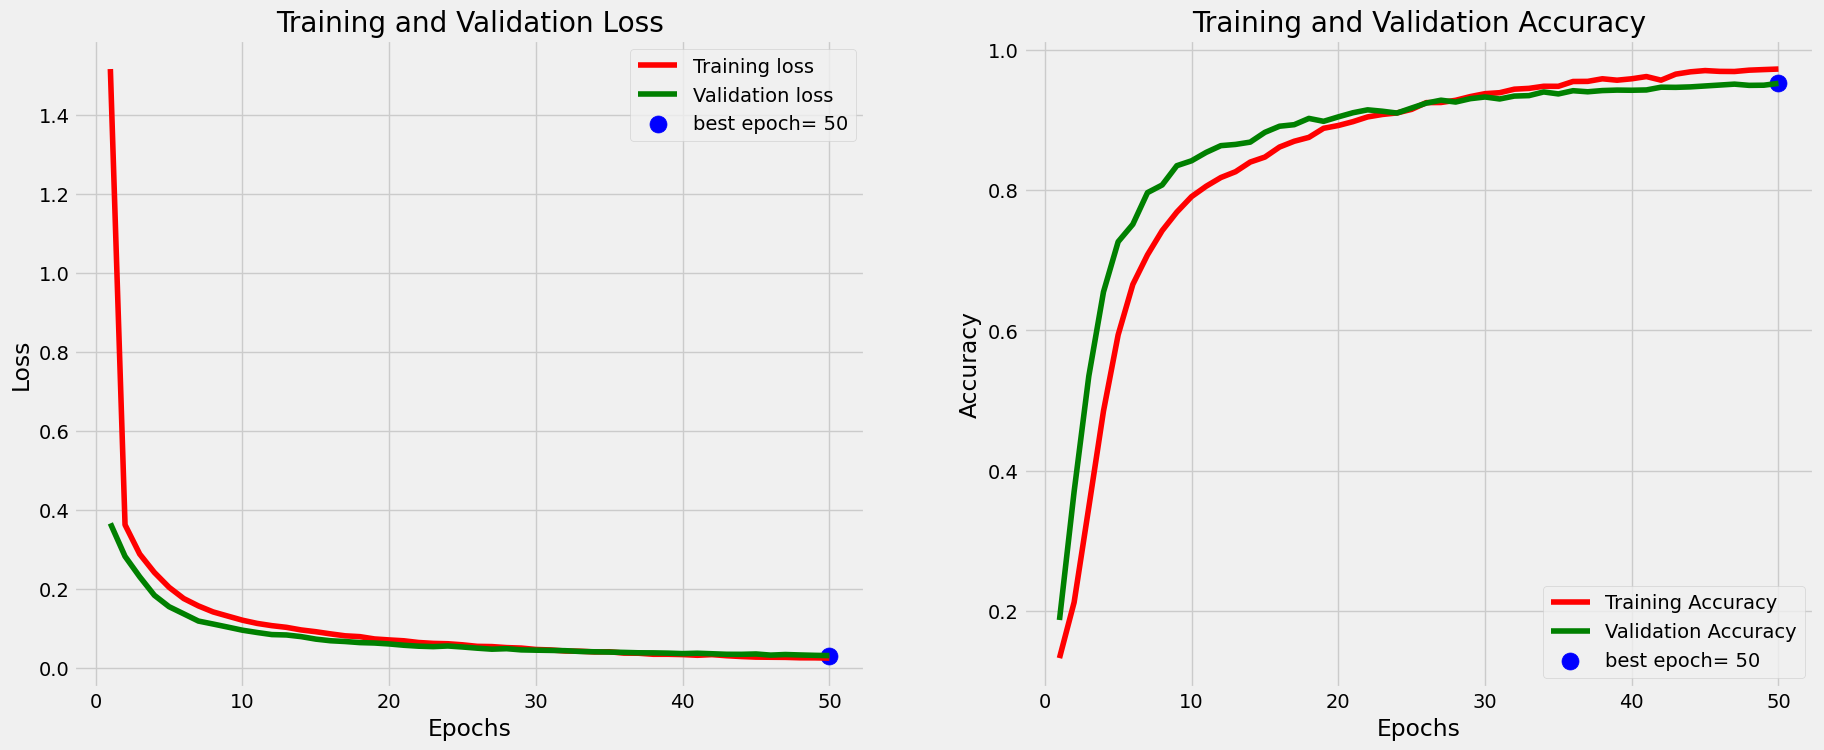

In [ ]:

def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(model_history,0)

###**Visualisasi Optimizer**

In [ ]:
#with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )



<ipython-input-16-19cf2cb61064>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 3.0413 - accuracy: 0.1199
Epoch 1: val_accuracy improved from -inf to 0.31581, saving model to model_CNN1.h5
18/18 [==============================] - 46s 1s/step - loss: 3.0413 - accuracy: 0.1199 - val_loss: 0.3169 - val_accuracy: 0.3158
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.2611
Epoch 2: val_accuracy improved from 0.31581 to 0.45322, saving model to model_CNN1.h5
18/18 [==============================] - 13s 721ms/step - loss: 0.3229 - accuracy: 0.2611 - val_loss: 0.2538 - val_accuracy: 0.4532
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.4236
Epoch 3: val_accuracy improved from 0.45322 to 0.60349, saving model to model_CNN1.h5
18/18 [==============================] - 14s 748ms/step - loss: 0.2677 - accuracy: 0.4236 - val_loss: 0.1974 - val_accuracy: 0.6035
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.

In [ ]:
#with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt1,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=100, verbose=1, callbacks=[checkpoint_callback]
    )


<ipython-input-18-edf67ec9928d>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.7406 - accuracy: 0.1351
Epoch 1: val_accuracy improved from -inf to 0.34700, saving model to model_CNN1.h5
18/18 [==============================] - 24s 1s/step - loss: 1.7406 - accuracy: 0.1351 - val_loss: 0.2944 - val_accuracy: 0.3470
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.3031
Epoch 2: val_accuracy improved from 0.34700 to 0.55551, saving model to model_CNN1.h5
18/18 [==============================] - 15s 811ms/step - loss: 0.3046 - accuracy: 0.3031 - val_loss: 0.2316 - val_accuracy: 0.5555
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.4733
Epoch 3: val_accuracy improved from 0.55551 to 0.67045, saving model to model_CNN1.h5
18/18 [==============================] - 14s 746ms/step - loss: 0.2513 - accuracy: 0.4733 - val_loss: 0.1816 - val_accuracy: 0.6704
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss

144/144 [==============================] - 2s 10ms/step


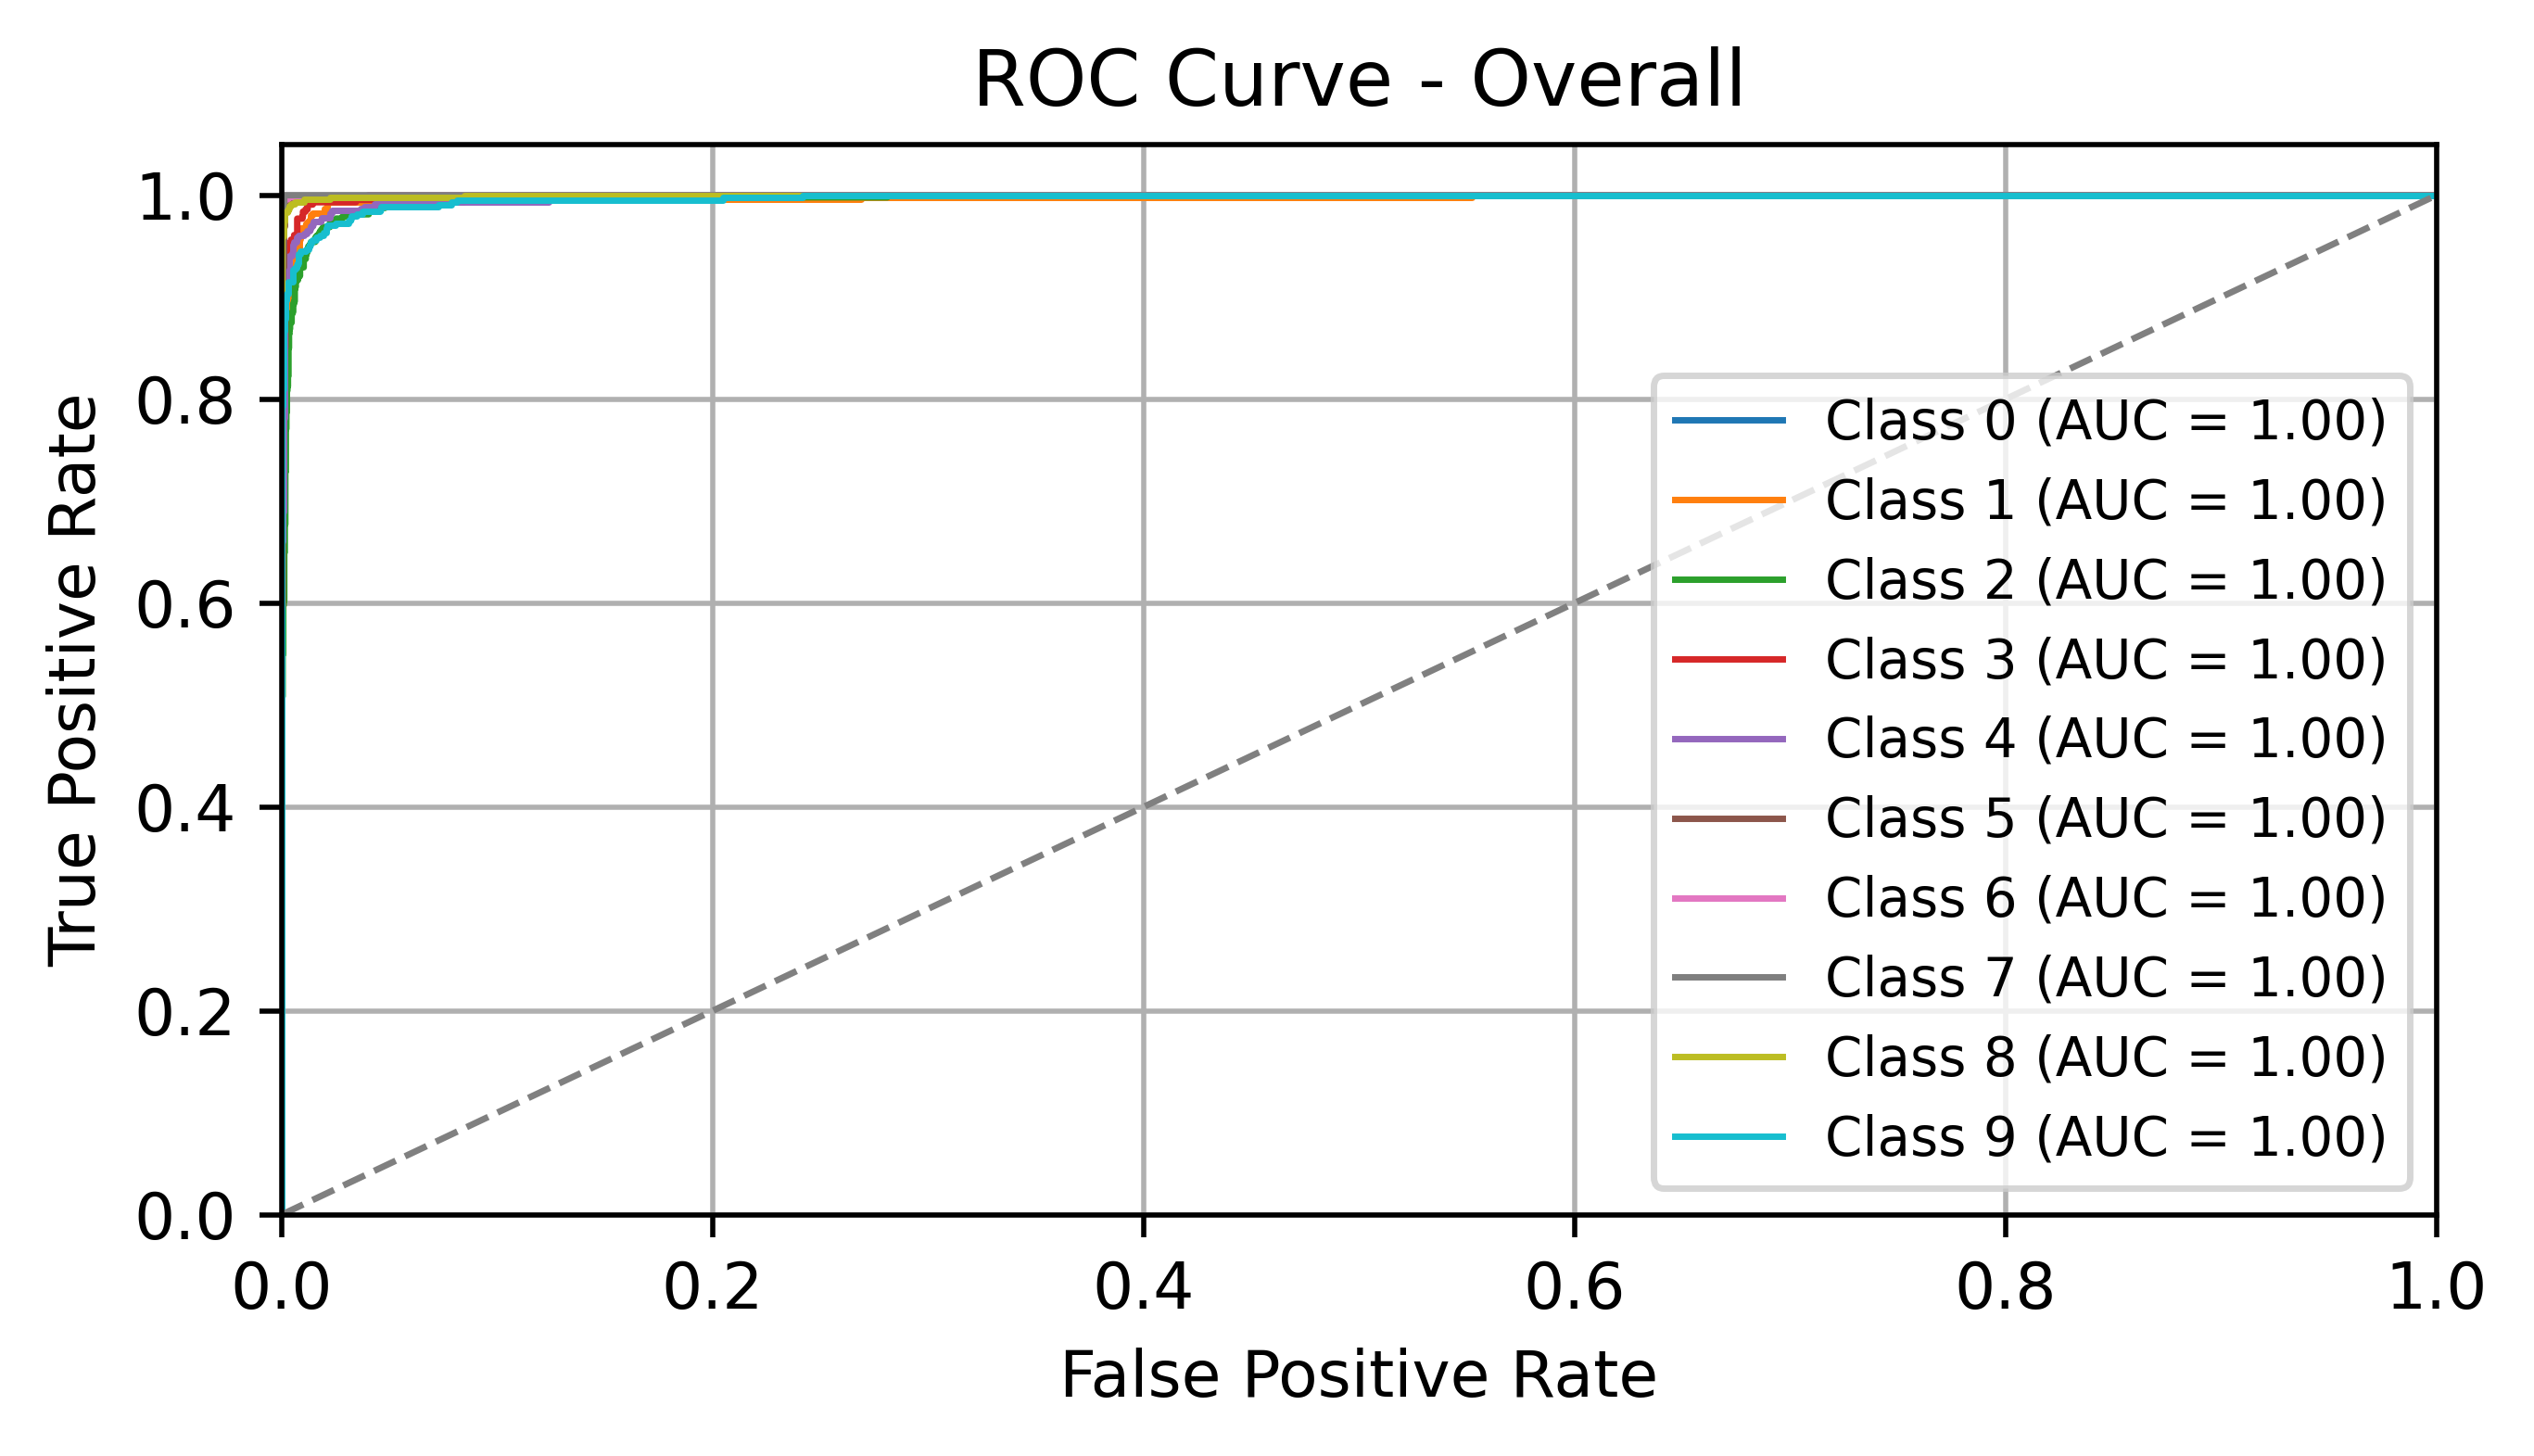

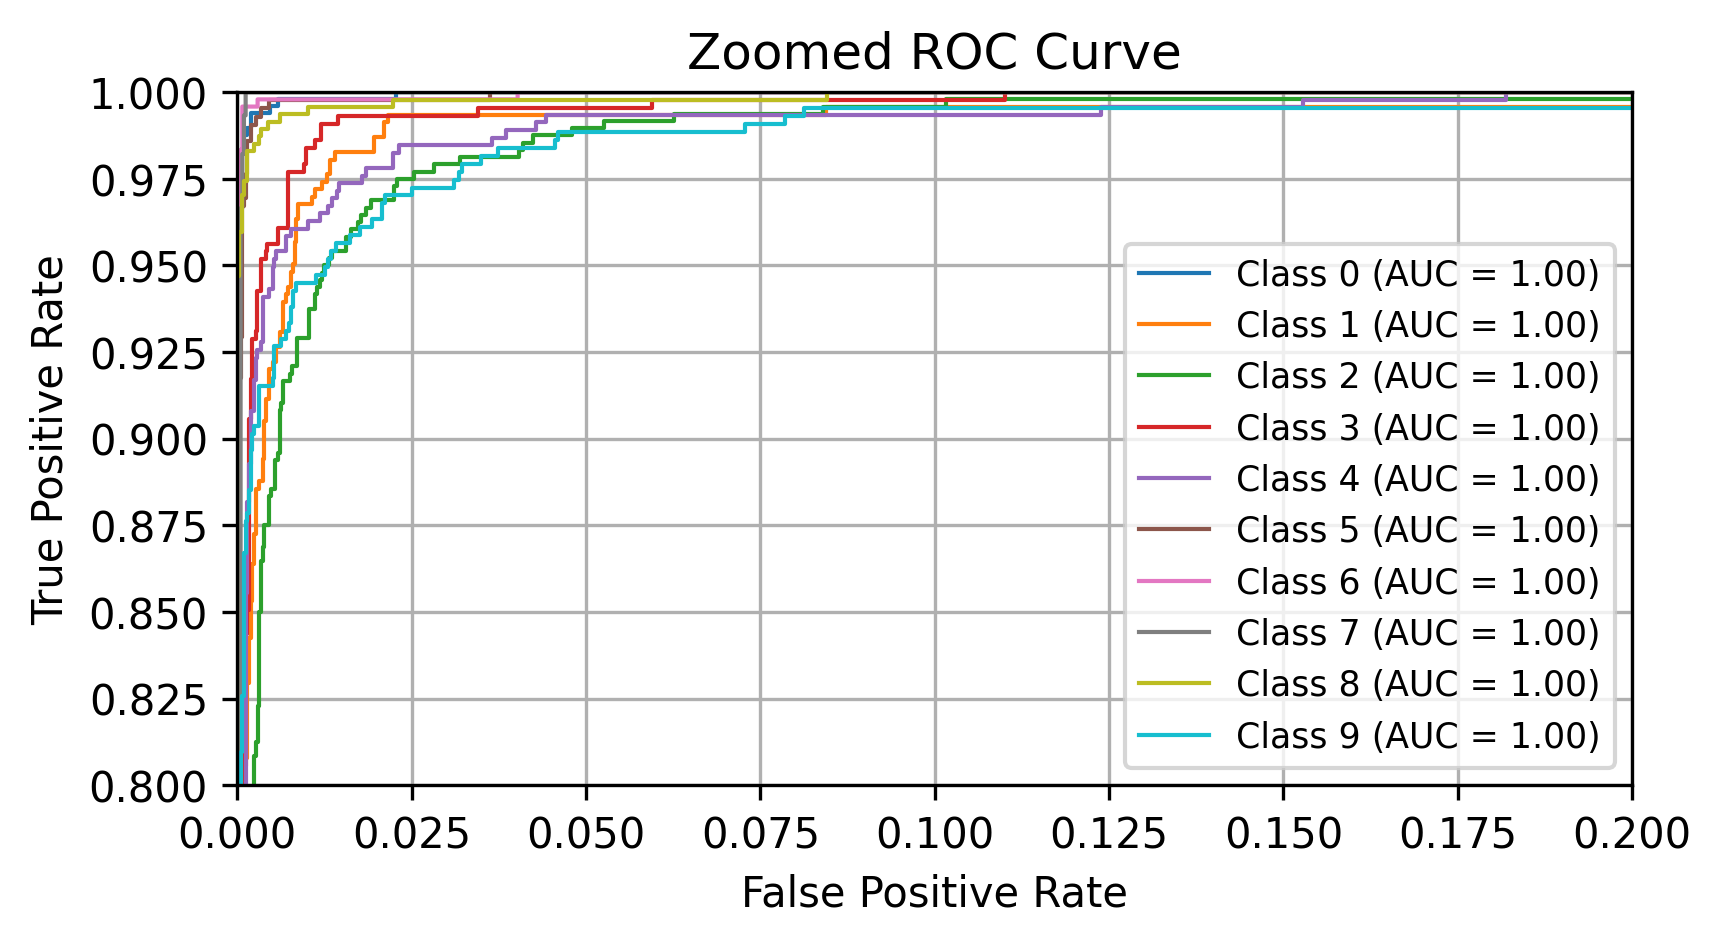

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
loaded_model = tf.keras.models.load_model('/content/model_CNN1.h5')
y_pred_prob = loaded_model.predict(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(0,10):  # num_classes adalah jumlah kelas (10 dalam kasus Anda)
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 3),dpi=500)  # Ukuran gambar untuk visualisasi ROC keseluruhan

for i in range(0,10):
    plt.plot(fpr[i], tpr[i], lw=1, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Overall')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()

# Membuat visualisasi zoom pada bagian kelengkungan garis ROC
plt.figure(figsize=(6, 3),dpi =300)  # Ukuran gambar untuk visualisasi zoom

for i in range(0,10):
    plt.plot(fpr[i], tpr[i], lw=1, label='Class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.xlim([0.0, 0.2])  # Batas x untuk zoom
plt.ylim([0.8, 1.0])  # Batas y untuk zoom
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed ROC Curve')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()


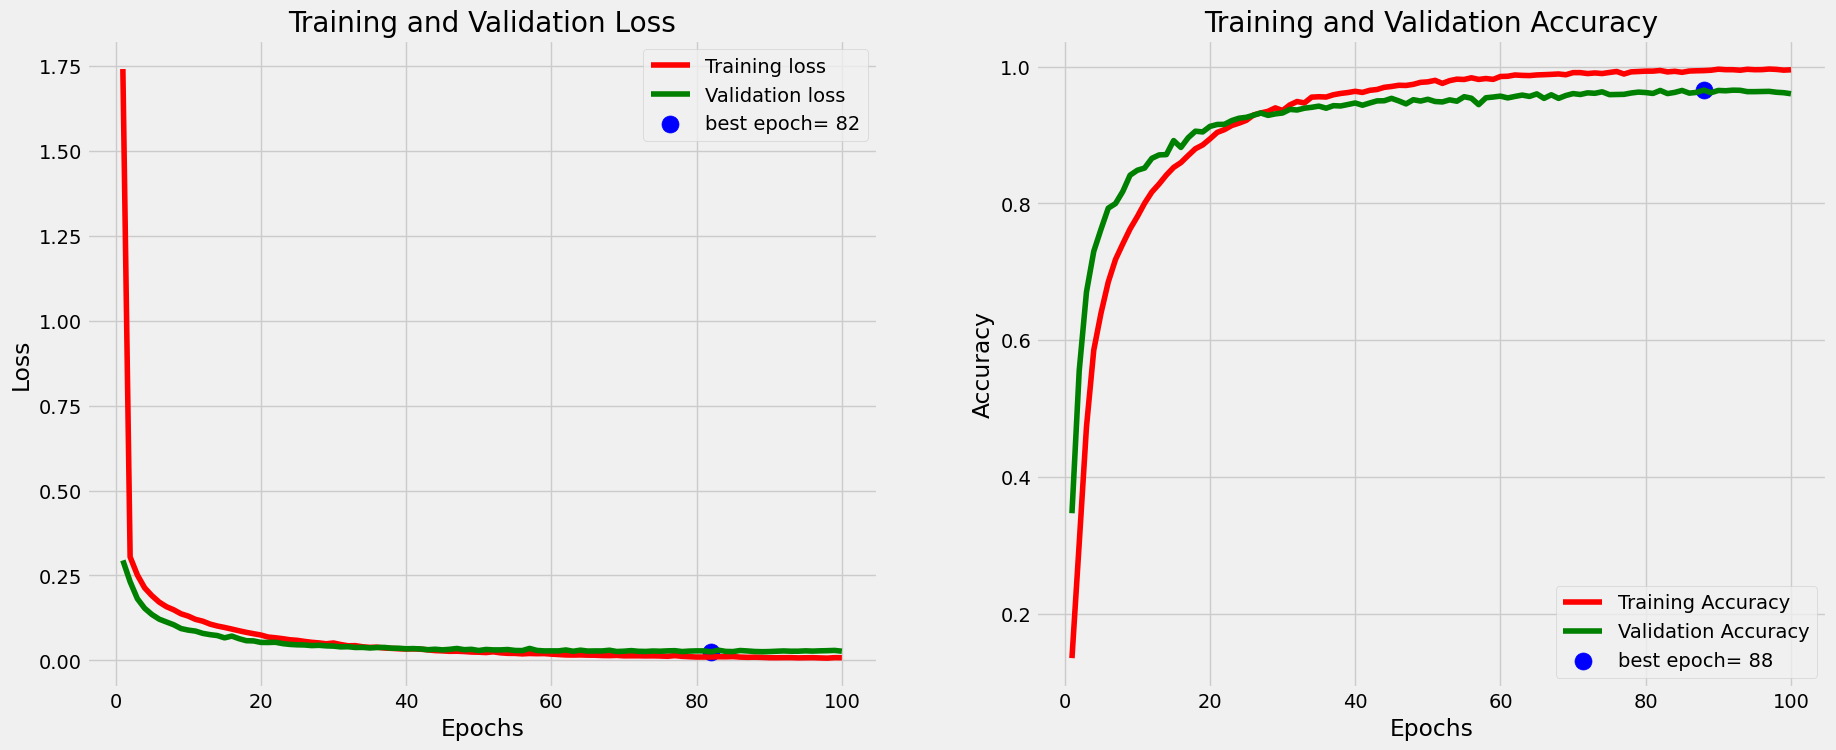

In [ ]:

def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(model_history,0)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
# Load the model from the SavedModel directory
loaded_model = tf.keras.models.load_model('/content/model_CNN1.h5')

# Generate model predictions on the test data
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create and print the classification report
report = classification_report(y_true, y_pred_classes)
print(report)
scores = loaded_model.evaluate(x_test, y_test)
print("Accuracy is :"+str(scores[1]*100)+" %")

144/144 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       490
           1       0.92      0.97      0.95       463
           2       0.94      0.91      0.93       480
           3       0.93      0.97      0.95       435
           4       0.95      0.94      0.95       457
           5       0.98      0.99      0.98       425
           6       0.99      1.00      0.99       481
           7       0.99      1.00      0.99       448
           8       0.98      0.99      0.98       470
           9       0.98      0.90      0.94       436

    accuracy                           0.97      4585
   macro avg       0.97      0.97      0.97      4585
weighted avg       0.97      0.97      0.97      4585

144/144 [==============================] - 2s 10ms/step - loss: 0.0263 - accuracy: 0.9655
Accuracy is :96.5539813041687 %


In [ ]:
#with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt2,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )


<ipython-input-16-1a8ccb4da082>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.0346 - accuracy: 0.1494
Epoch 1: val_accuracy improved from -inf to 0.27023, saving model to model_CNN1.h5
18/18 [==============================] - 48s 1s/step - loss: 1.0346 - accuracy: 0.1494 - val_loss: 0.3124 - val_accuracy: 0.2702
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.2824
Epoch 2: val_accuracy improved from 0.27023 to 0.54613, saving model to model_CNN1.h5
18/18 [==============================] - 14s 748ms/step - loss: 0.3108 - accuracy: 0.2824 - val_loss: 0.2229 - val_accuracy: 0.5461
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.4556
Epoch 3: val_accuracy did not improve from 0.54613
18/18 [==============================] - 15s 810ms/step - loss: 0.2550 - accuracy: 0.4556 - val_loss: 0.2282 - val_accuracy: 0.5276
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.1983 - accuracy: 0.6031
Epoch 4: va

In [ ]:
#with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt3,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )


<ipython-input-15-b548db9f204a>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 4.0169 - accuracy: 0.1112
Epoch 1: val_accuracy improved from -inf to 0.21003, saving model to model_CNN1.h5
18/18 [==============================] - 47s 1s/step - loss: 4.0169 - accuracy: 0.1112 - val_loss: 0.3352 - val_accuracy: 0.2100
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.1754
Epoch 2: val_accuracy did not improve from 0.21003
18/18 [==============================] - 15s 794ms/step - loss: 0.3646 - accuracy: 0.1754 - val_loss: 0.4397 - val_accuracy: 0.1832
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.2097
Epoch 3: val_accuracy did not improve from 0.21003
18/18 [==============================] - 14s 744ms/step - loss: 0.4825 - accuracy: 0.2097 - val_loss: 1.2434 - val_accuracy: 0.1051
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.2415
Epoch 4: val_accuracy improved from 0.21003 to

In [ ]:
#with tpu_strategy.scope():
model1.compile(loss="binary_crossentropy", optimizer=opt4,metrics=["accuracy"])
model_history = model1.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=50, verbose=1, callbacks=[checkpoint_callback]
    )


<ipython-input-16-800dacda4a6e>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model1.fit_generator(


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.9460 - accuracy: 0.1261
Epoch 1: val_accuracy improved from -inf to 0.22552, saving model to model_CNN1.h5
18/18 [==============================] - 46s 1s/step - loss: 0.9460 - accuracy: 0.1261 - val_loss: 0.3161 - val_accuracy: 0.2255
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.1599
Epoch 2: val_accuracy improved from 0.22552 to 0.27394, saving model to model_CNN1.h5
18/18 [==============================] - 14s 740ms/step - loss: 0.3980 - accuracy: 0.1599 - val_loss: 0.3038 - val_accuracy: 0.2739
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.1824
Epoch 3: val_accuracy improved from 0.27394 to 0.31756, saving model to model_CNN1.h5
18/18 [==============================] - 14s 752ms/step - loss: 0.3731 - accuracy: 0.1824 - val_loss: 0.2956 - val_accuracy: 0.3176
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.

In [ ]:
import pandas as pd
history_dict = {
    'loss': model_history.history['loss'],
    'accuracy': model_history.history['accuracy'],
    'val_loss': model_history.history['val_loss'],
    'val_accuracy': model_history.history['val_accuracy']
}
history_df = pd.DataFrame(history_dict)
history_df.to_csv('model_history_adamax.csv', index=False)


In [ ]:
def plot_optimizer_history(history_data, optimizer_names):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    line_styles = ['-', '--', '-.', ':']

    for i, optimizer in enumerate(optimizer_names):
        plt.plot(history_data[i], label=optimizer, lw=1.5, color=colors[i % len(colors)], linestyle=line_styles[i % len(line_styles)])

    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('Comparison of Optimizers', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('COmpare_Optimizer.png', bbox_inches='tight')


In [ ]:
adam_history = pd.read_csv('/content/model_history_adam.csv')
nadam_history = pd.read_csv('/content/model_history_nadam.csv')
adamax_history = pd.read_csv('/content/model_history_adamax.csv')
rmsprop_history = pd.read_csv('/content/model_history_rmsprop.csv')
adagrad_history = pd.read_csv('/content/model_history_adagrad.csv')

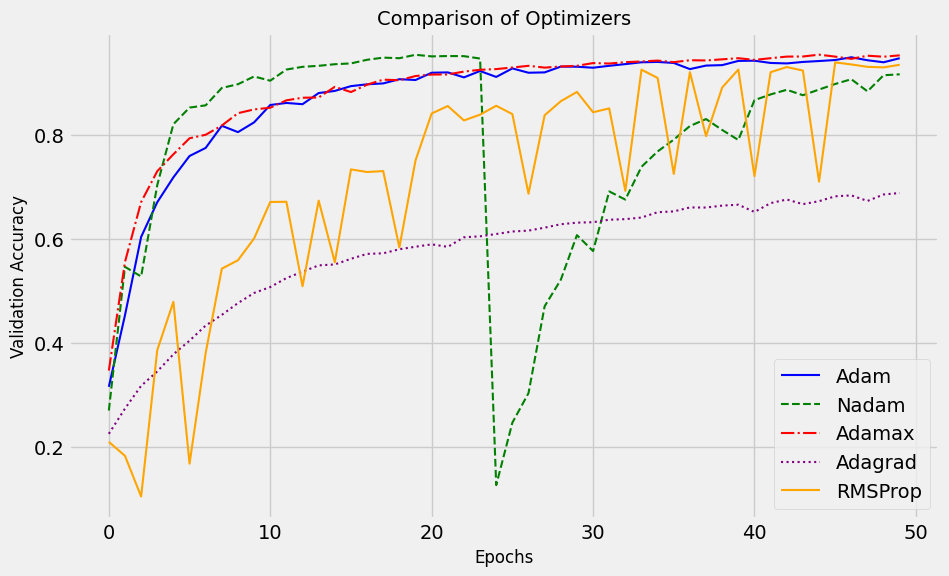

<Figure size 640x480 with 0 Axes>

In [ ]:
adam_history = adam_history['val_accuracy'] # Contoh data history untuk Adam
nadam_history = nadam_history['val_accuracy'] # Contoh data history untuk Nadam
adamax_history = adamax_history['val_accuracy'][:50] # Contoh data history untuk Adamax
adagrad_history = adagrad_history['val_accuracy']  # Contoh data history untuk Adagrad
rmsprop_history = rmsprop_history['val_accuracy'] # Contoh data history untuk RMSProp

optimizer_names = ['Adam', 'Nadam', 'Adamax', 'Adagrad', 'RMSProp']
history_data = [adam_history, nadam_history, adamax_history, adagrad_history, rmsprop_history]

plot_optimizer_history(history_data, optimizer_names)


In [ ]:
plt.savefig('COmpare_Optimizer.png', bbox_inches='tight')